# Suavizado de las series temporales

### Suavizar cambios bruscos de temperatura superiores a 0.3ºC

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import plotly.graph_objects as go
import math
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
NUM_SERIES_ESTUDIO = 3 # Número de series temporales más representarivas que queremos visualizar
RANGE_VISUALIZ = [35.0, 38.0] # Rango de temperaturas para la visualización

fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('h') # Para alinear las gráficas

In [3]:
# Cargamos los datos de las muestras de ovulación con valores entre [35.7, 37.7]
with open("../procData/muestras_ovul_filt2.pkl", "rb") as f:
    muestras_ovul = pickle.load(f)

In [4]:
# Recogemos los nombres de las series temporales con las que trabajamos
name_series = muestras_ovul.keys()
num_series = len(name_series)
num_series

61

In [5]:
# Crear una lista con (id, número de valores no nulos)
numero_no_nulos = [
    (k, v["serie"]["result"].notna().sum()) for k, v in muestras_ovul.items()
]

# Ordenar de mayor a menor cantidad de valores no nulos
numero_no_nulos.sort(key=lambda x: x[1], reverse=True)

numero_no_nulos

[('TU046_3', np.int64(14327)),
 ('TU078_1', np.int64(14122)),
 ('TU074_4', np.int64(13581)),
 ('TU021_1', np.int64(13460)),
 ('TU013_2', np.int64(13457)),
 ('AN003_1', np.int64(13325)),
 ('AN001_3', np.int64(13245)),
 ('TU030_2', np.int64(13227)),
 ('TU046_1', np.int64(13098)),
 ('TU063_2', np.int64(12926)),
 ('TU023_2', np.int64(12868)),
 ('TU067_2', np.int64(12760)),
 ('AN010_3', np.int64(12702)),
 ('AN002_2', np.int64(12696)),
 ('TU074_2', np.int64(12684)),
 ('TU074_3', np.int64(12684)),
 ('TU038_1', np.int64(12631)),
 ('TU080_1', np.int64(12602)),
 ('TU060_2', np.int64(12546)),
 ('TU054_1', np.int64(12535)),
 ('AN008_1', np.int64(12468)),
 ('AN009_3', np.int64(12466)),
 ('TU038_2', np.int64(12397)),
 ('TU046_2', np.int64(12043)),
 ('TU017_1', np.int64(12034)),
 ('TU036_4', np.int64(11978)),
 ('TU063_3', np.int64(11963)),
 ('TU023_1', np.int64(11691)),
 ('TU019_2', np.int64(11631)),
 ('AN007_1', np.int64(11625)),
 ('TU034_2', np.int64(11557)),
 ('TU061_2', np.int64(11474)),
 ('AN008

In [6]:
def corregir_series(muestras_ovul, umbral_cambio=0.3, factor_lowess=0.5,
                    ventana_estudio=60, ventana_antes=30, ventana_despues=30, 
                    ampliar_correccion = 8, suavizado_lateral=30):  # Todo en minutos

    muestras_corregidas = {}

    # Los timestamps son cada dos minutos:
    ventana_estudio = ventana_estudio // 2
    ventana_antes = ventana_antes // 2
    ventana_despues = ventana_despues // 2
    ampliar_correccion = ampliar_correccion // 2
    suavizado_lateral = suavizado_lateral // 2

    for clave, entrada in muestras_ovul.items():
        serie = entrada["serie"].copy()
        serie = serie.sort_values("resultTimestamp").reset_index(drop=True)

        temps = serie["result"].copy()
        times = serie["resultTimestamp"]

        minutos = ((times - times.iloc[0]) / pd.Timedelta(minutes=1)).values
        temps_array = temps.values.astype('float64')

        i = ventana_antes + ventana_estudio // 2

        while i < len(temps_array) - (ventana_despues + ventana_estudio // 2):
            if np.isnan(temps_array[i]):
                i += 1
                continue

            # Índices de ventanas
            idx_ventana_antes = np.arange(i - (ventana_antes + ventana_estudio // 2), i - ventana_estudio // 2)
            idx_ventana_antes = [idx for idx in idx_ventana_antes if not np.isnan(temps_array[idx])]
            if len(idx_ventana_antes) < 5:
                i += 1
                continue

            idx_ventana_despues = np.arange(i + ventana_estudio // 2, i + ventana_despues + ventana_estudio // 2)
            idx_ventana_despues = [idx for idx in idx_ventana_despues if not np.isnan(temps_array[idx])]
            if len(idx_ventana_despues) < 5:
                i += 1
                continue

            idx_ventana_estudio = np.arange(i - ventana_estudio // 2, i + ventana_estudio // 2)
            idx_ventana_estudio = [idx for idx in idx_ventana_estudio if not np.isnan(temps_array[idx])]
            if len(idx_ventana_estudio) < 5:
                i += 1
                continue

            # Estadísticas de comparación
            media_antes = np.mean([temps_array[idx] for idx in idx_ventana_antes])
            media_despues = np.mean([temps_array[idx] for idx in idx_ventana_despues])
            min_ventana = np.min([temps_array[idx] for idx in idx_ventana_estudio])
            max_ventana = np.max([temps_array[idx] for idx in idx_ventana_estudio])

            diferencia_antes = max(abs(media_antes - min_ventana), abs(media_antes - max_ventana))
            diferencia_despues = max(abs(media_despues - min_ventana), abs(media_despues - max_ventana))

            if (diferencia_antes > umbral_cambio) and (diferencia_despues > umbral_cambio):
                # Aplanar usando media de ambos lados
                idx_inicio = max(0, i - ventana_estudio // 2 - ampliar_correccion)
                idx_fin = min(len(temps_array), i + ventana_estudio // 2 + ampliar_correccion)
                idx_aplanado = np.arange(idx_inicio, idx_fin)
                idx_aplanado = [idx for idx in idx_aplanado if not np.isnan(temps_array[idx])]

                media_aplanado = (media_antes + media_despues) / 2
                for idx in idx_aplanado:
                    temps_array[idx] = media_aplanado

                # Suavizado en los bordes con LOWESS
                suavizar_margen = suavizado_lateral // 2

                for borde in [idx_inicio, idx_fin - 1]:
                    idx_borde_ini = max(0, borde - suavizar_margen)
                    idx_borde_fin = min(len(temps_array), borde + suavizar_margen)
                    x_borde = minutos[idx_borde_ini:idx_borde_fin]
                    y_borde = temps_array[idx_borde_ini:idx_borde_fin]

                    mask_valid_borde = ~np.isnan(y_borde)
                    x_valid = x_borde[mask_valid_borde]
                    y_valid = y_borde[mask_valid_borde]

                    if len(y_valid) >= 5:
                        try:
                            y_suav = lowess(y_valid, x_valid, frac=factor_lowess, return_sorted=False)
                            j = 0
                            for k in range(idx_borde_ini, idx_borde_fin):
                                if not np.isnan(temps_array[k]):
                                    temps_array[k] = y_suav[j]
                                    j += 1
                        except Exception as e:
                            print(f"[WARN] Error LOWESS en borde {clave}, índice {borde}: {e}")

                i += ventana_estudio
            else:
                i += 1

        serie["result"] = temps_array
        muestras_corregidas[clave] = {
            "serie": serie,
            "ovul": entrada["ovul"]
        }

    return muestras_corregidas


In [7]:
muestras_corregidas = corregir_series(muestras_ovul)

In [8]:
muestras_corregidas = corregir_series(muestras_corregidas)

In [29]:
# Función para mostrar gráficamente las series temporales de list_ids con matplotlib
def print_series(list_ids, muestras):

    for id in list_ids:
        serie = muestras[id]["serie"]

        # Convertimos las fechas a días relativos a la ovulación
        x = (serie["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y = serie["result"]

        plt.figure(figsize=(8, 4))

        # Puntos de la serie
        plt.scatter(x, y, s=10, label=f'Serie {id}', alpha=0.8, color='#2980B9')

        # Línea vertical discontinua en el día 0 (ovulación)
        plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
        #plt.text(0, 38.7, 'Ovulación', color='red', ha='center', va='bottom')

        # Etiquetas y título
        plt.title(f'Serie {id}')
        plt.xlabel('Día relativo a la ovulación')
        plt.ylabel('Temperatura (°C)')
        plt.grid(True)

        plt.ylim(RANGE_VISUALIZ[0], RANGE_VISUALIZ[1])  

        plt.tight_layout()
        plt.show()


In [30]:
def print_series_comparadas(list_ids):
    for id in list_ids:
        serie_ori = muestras_ovul[id]["serie"]
        serie_cor = muestras_corregidas[id]["serie"]

        # Convertimos a días relativos a ovulación
        x_ori = (serie_ori["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y_ori = serie_ori["result"]

        x_cor = (serie_cor["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y_cor = serie_cor["result"]

        fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)

        # Serie original
        axs[0].scatter(x_ori, y_ori, s=10, alpha=0.7, color='#2980B9')
        axs[0].axvline(x=0, color='red', linestyle='--', linewidth=1.5)
        axs[0].set_title(f"Original")
        axs[0].set_xlabel("Día relativo a la ovulación")
        axs[0].set_ylabel("Temperatura (°C)")
        axs[0].grid(True)
        axs[0].set_ylim(RANGE_VISUALIZ)

        # Serie corregida
        axs[1].scatter(x_cor, y_cor, s=10, alpha=0.7, color='#1E8449')
        axs[1].axvline(x=0, color='red', linestyle='--', linewidth=1.5)
        axs[1].set_title(f"Corregida")
        axs[1].set_xlabel("Día relativo a la ovulación")
        axs[1].grid(True)
        axs[1].set_ylim(RANGE_VISUALIZ)

        fig.suptitle(f"Serie {id}", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [31]:
# Crear una lista con (id, número de valores no nulos)
numero_no_nulos_corr = [
    (k, v["serie"]["result"].notna().sum()) for k, v in muestras_corregidas.items()
]

# Ordenar de mayor a menor cantidad de valores no nulos
numero_no_nulos_corr.sort(key=lambda x: x[1], reverse=True)

In [12]:
print("Número de valores no nulos por serie antes y después de la corrección:")
print("Serie  | Original | Corregida |  Diferencia")
for i in range(num_series):
    print(numero_no_nulos_corr[i][0], " ", 
          numero_no_nulos[i][1], "    ", 
          numero_no_nulos_corr[i][1], "      ", 
          numero_no_nulos[i][1]-numero_no_nulos_corr[i][1])

Número de valores no nulos por serie antes y después de la corrección:
Serie  | Original | Corregida |  Diferencia
TU046_3   14327      14327        0
TU078_1   14122      14122        0
TU074_4   13581      13581        0
TU021_1   13460      13460        0
TU013_2   13457      13457        0
AN003_1   13325      13325        0
AN001_3   13245      13245        0
TU030_2   13227      13227        0
TU046_1   13098      13098        0
TU063_2   12926      12926        0
TU023_2   12868      12868        0
TU067_2   12760      12760        0
AN010_3   12702      12702        0
AN002_2   12696      12696        0
TU074_2   12684      12684        0
TU074_3   12684      12684        0
TU038_1   12631      12631        0
TU080_1   12602      12602        0
TU060_2   12546      12546        0
TU054_1   12535      12535        0
AN008_1   12468      12468        0
AN009_3   12466      12466        0
TU038_2   12397      12397        0
TU046_2   12043      12043        0
TU017_1   12034      

In [13]:
ids_estudio = [id for (id, n) in numero_no_nulos_corr[:NUM_SERIES_ESTUDIO]]

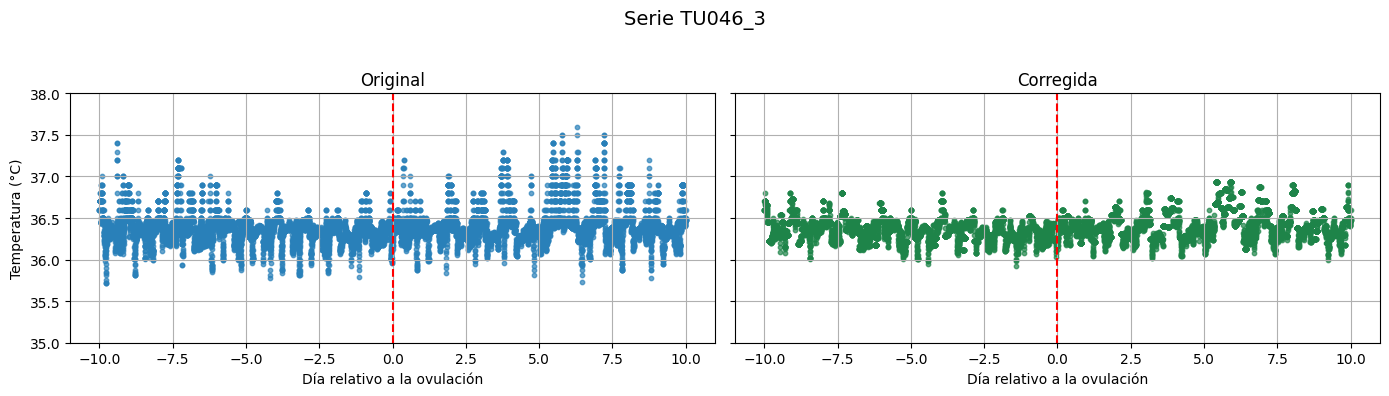

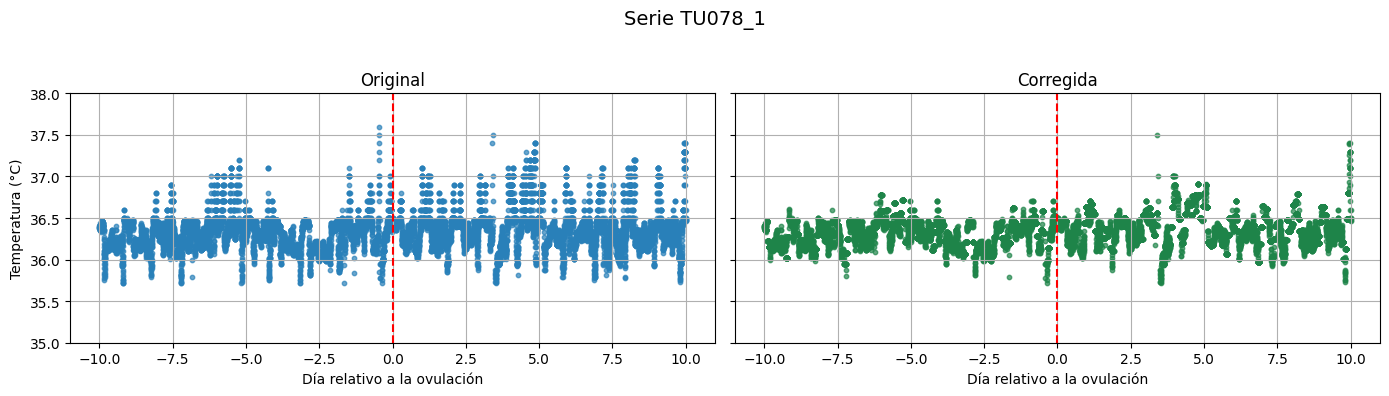

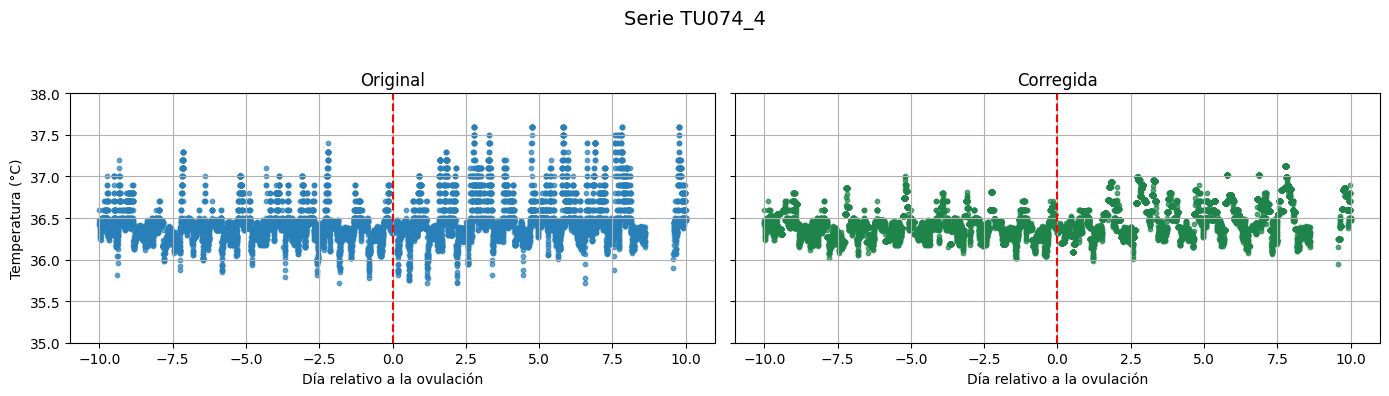

In [32]:
print_series_comparadas(ids_estudio)

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Tiene dos modos de mostrar cada serie original y corregida: solapadas o separadas

def print_series_zoom(muestras_orig, muestras_corr, list_ids, modo_visualizacion='solapadas'):

    fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('h')

    for id in list_ids:
        serie_orig = muestras_orig[id]["serie"]
        serie_corr = muestras_corr[id]["serie"]

        x_orig = (serie_orig["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y_orig = serie_orig["result"]
        x_corr = (serie_corr["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y_corr = serie_corr["result"]

        if modo_visualizacion == 'solapadas':
            fig = go.Figure()

            fig.add_trace(go.Scatter(
                x=x_orig,
                y=y_orig,
                mode='markers',
                name=f'{id} (original)',
                marker=dict(size=4, color='#2980B9'),
            ))

            fig.add_trace(go.Scatter(
                x=x_corr,
                y=y_corr,
                mode='markers',
                name=f'{id} (corregida)',
                marker=dict(size=4, color='#1E8449' )
            ))

            fig.add_shape(
                type="line", x0=0, x1=0, y0=35.0, y1=37.7,
                line=dict(color="red", width=2, dash="dash")
            )
            fig.add_annotation(
                x=0, y=37.7, text="Ovulación", showarrow=False,
                yanchor="bottom", font=dict(color="red")
            )

            fig.update_layout(
                title=f"Serie {id}: Original vs Corregida",
                xaxis_title="Día relativo a la ovulación",
                yaxis_title="Temperatura (°C)",
                hovermode="x unified",
                template="plotly_white",
                height=400
            )
            fig.update_yaxes(range=RANGE_VISUALIZ)

        elif modo_visualizacion == 'separadas':
            fig = make_subplots(rows=2, cols=1,
                                shared_xaxes=True,
                                subplot_titles=[f"{id} (original)", f"{id} (corregida)"],
                                vertical_spacing=0.1)

            fig.add_trace(go.Scatter(
                x=x_orig,
                y=y_orig,
                mode='markers',
                name='Original',
                marker=dict(size=4, color='#2980B9'),
            ), row=1, col=1)

            fig.add_trace(go.Scatter(
                x=x_corr,
                y=y_corr,
                mode='markers',
                name='Corregida',
                marker=dict(size=4, color='#1E8449')
            ), row=2, col=1)

            # Línea de ovulación en ambas subgráficas
            for row in [1, 2]:
                fig.add_shape(
                    type="line", x0=0, x1=0, y0=35.0, y1=37.7,
                    line=dict(color="red", width=2, dash="dash"),
                    row=row, col=1
                )
                fig.add_annotation(
                    x=0, y=37.7, text="Ovulación", showarrow=False,
                    yanchor="bottom", font=dict(color="red"),
                    row=row, col=1
                )

            fig.update_layout(
                title_text=f"Serie {id}: Original y Corregida",
                height=600,
                template="plotly_white",
                hovermode="x unified"
            )
            fig.update_yaxes(range=RANGE_VISUALIZ, row=1, col=1)
            fig.update_yaxes(range=RANGE_VISUALIZ, row=2, col=1)
            fig.update_xaxes(title_text="Día relativo a la ovulación", row=2, col=1)
            fig.update_yaxes(title_text="Temperatura (°C)", row=1, col=1)
            fig.update_yaxes(title_text="Temperatura (°C)", row=2, col=1)

        else:
            raise ValueError("El parámetro 'modo_visualizacion' debe ser 'solapadas' o 'separadas'.")
        
        fig.show()


In [43]:
print_series_zoom(muestras_orig=muestras_ovul, muestras_corr=muestras_corregidas, list_ids=ids_estudio, modo_visualizacion="separadas")

In [12]:
with open("../procData/muestras_ovul_suaviz.pkl", "wb") as f:
    pickle.dump(muestras_corregidas, f)

In [ ]:
print_series([id for (id, n) in numero_no_nulos_corr], muestras_corregidas)